In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

Exploring the data to see which locations give us the most data based on the number of reviews for beers of that country and number of reviews coming out of that country.

BeerAdvocate exploration

In [2]:
#number of beers per country
breweries = pd.read_csv('../../minimizedData/BA_breweries_small.csv')

In [3]:

# Group by country (location) and calculate total number of breweries and beers
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

print(country_stats.shape)
#There are 297 different locations where beer originates from

filtered_countries = country_stats[country_stats['total_beers'] >= 4]
print(filtered_countries.shape)
print("there are a total of 297 locations")
#Do what countries do we automatically remove for our analysis since they don't have enough beers to analyse
#How much do we want to remove

(297, 3)
(229, 3)
there are a total of 297 locations


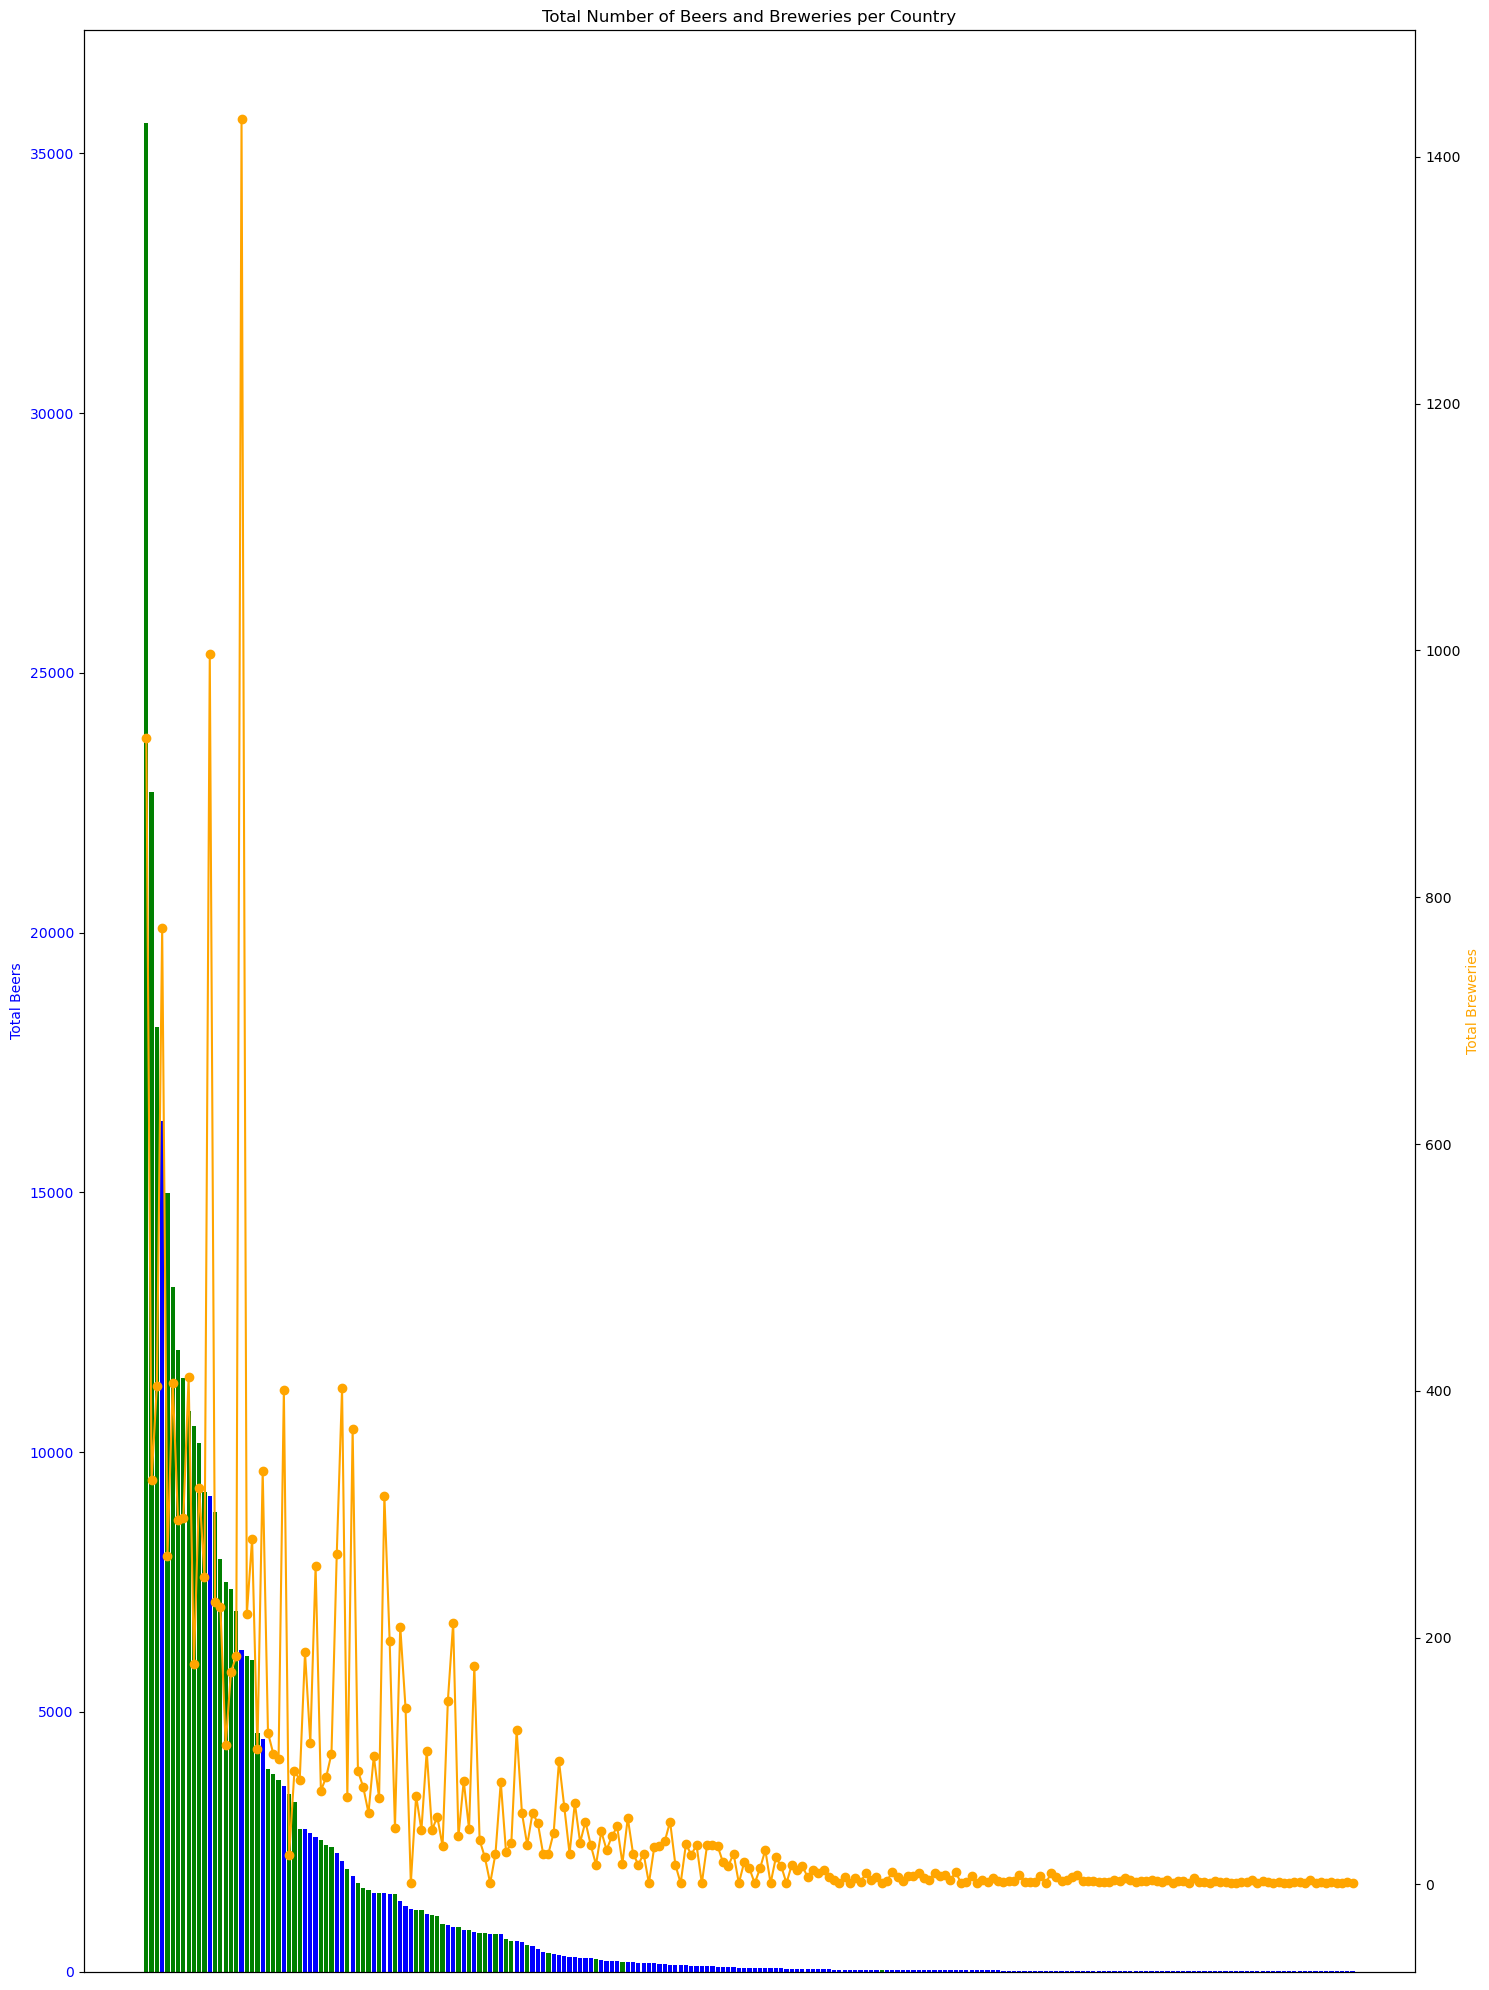

In [4]:
# Plotting the total number of beers and breweries for each country

filtered_countries = filtered_countries.sort_values(by='total_beers', ascending=False)
fig, ax1 = plt.subplots(figsize=(15, 20))

bar_colors = ['green' if country.startswith('United States,') else 'blue' for country in filtered_countries['location']]

# Bar plot for total beers
ax1.bar(filtered_countries['location'], filtered_countries['total_beers'], color=bar_colors, label='Total Beers')
#ax1.set_xlabel('Country')
ax1.set_ylabel('Total Beers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks([])

# Overlay line plot for total breweries
ax2 = ax1.twinx()
ax2.plot(filtered_countries['location'], filtered_countries['total_breweries'], color='orange', marker='o', label='Total Breweries')
ax2.set_ylabel('Total Breweries', color='orange')
plt.xticks([])

# Adding title and showing legend
plt.title('Total Number of Beers and Breweries per Country')
fig.tight_layout()
plt.show()


In [5]:
users = pd.read_csv('../../minimizedData/BA_users_small.csv')
print(users.head())
print("Quick stats on the users")
print("total number of users:", users.shape[0])
#remove users with unknown locations
users = users.dropna(subset=['location'])
print("Number of users with known locations:", users.shape[0])
print("Users originate from: ",users['location'].dropna().nunique() , "different locations")

   Unnamed: 0  nbr_ratings                user_id                   location
0           0         7820         nmann08.184925  United States, Washington
1           1         2521     stjamesgate.163714    United States, New York
2           2         1797          mdagnew.19527           Northern Ireland
3           3           31  helloloser12345.10867           Northern Ireland
4           4          604        cypressbob.3708           Northern Ireland
Quick stats on the users
total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations


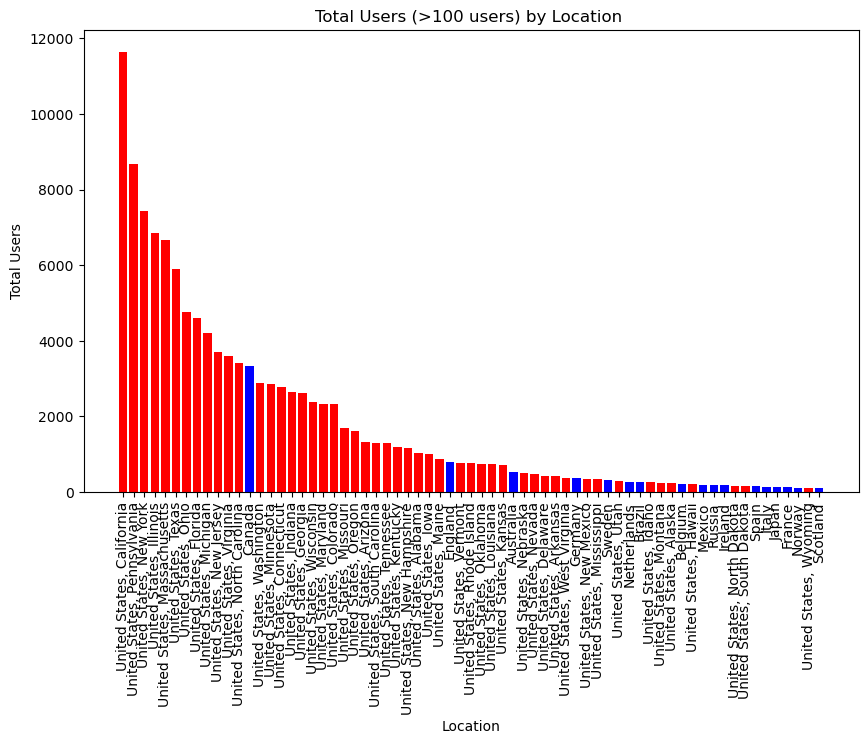

In [6]:
#For illustration purposes I just plotted those with more than 100 users otherwise the plot looks gross
user_counts = users.groupby('location').size().reset_index(name='total_users')
user_counts = user_counts[user_counts['total_users'] >= 100]
user_counts = user_counts.sort_values(by='total_users', ascending=False)
user_counts['color'] = user_counts['location'].apply(lambda x: 'red' if x.startswith('United States,') else 'blue')

plt.figure(figsize=(10, 6))
plt.bar(user_counts['location'], user_counts['total_users'], color=user_counts['color'])
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users (>100 users) by Location ')
plt.xticks(rotation=90)
#plt.xticks([])
plt.show()


In [7]:
us_users = users[users['location'].str.startswith('United States,')]
#Group by location and count the number of users
us_user_counts = us_users.groupby('location').size().reset_index(name='total_users')

#Sort the DataFrame by the total number of users
us_user_counts = us_user_counts.sort_values(by='total_users', ascending=False)



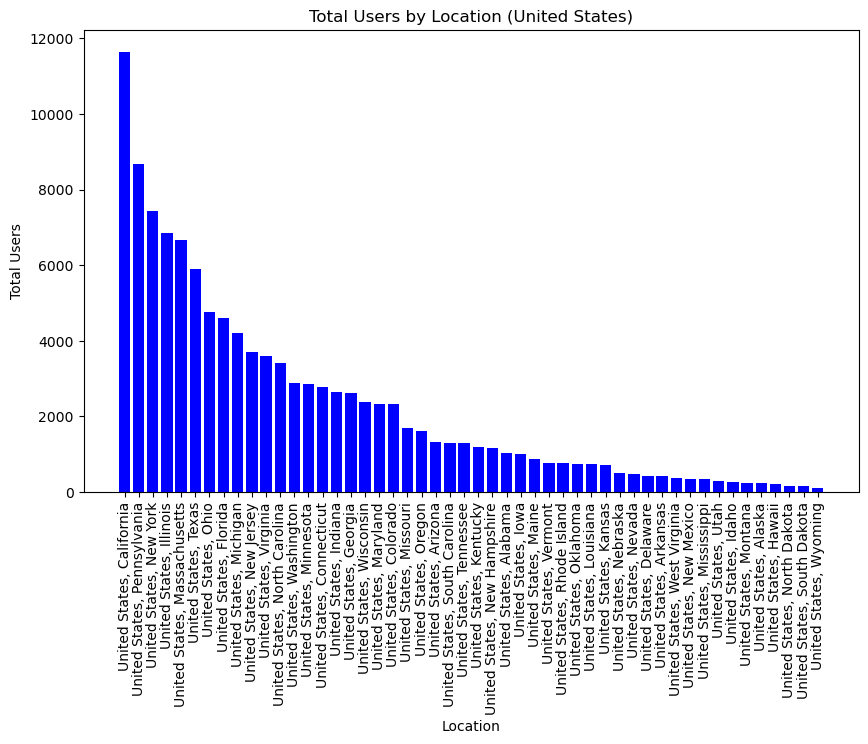

In [8]:
#Plotting US users distribution
plt.figure(figsize=(10, 6))
plt.bar(us_user_counts['location'], us_user_counts['total_users'], color='blue')
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users by Location (United States)')
plt.xticks(rotation=90)
plt.show()

In [9]:
#Remove ratings where user_location and beer location is missing (NaN)
BA_merged = pd.read_csv('../../minimizedData/Modified/BA_ratbeer.csv')
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]
BA_merged_cleaned = BA_merged[BA_merged['beer_location'].notna()]

#Local reviews (reviews written by people from one country reviewing beers from that same country)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

#Non-local reviews (reviews written by people for beers from other countries)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

#Total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

#Merge the dataframes
country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

#Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

#Sort the DataFrame by the total number of local reviews in ascending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)




LOCAL REVIEWS: number of reviews from a specific country for beers of the same country

NON LOCAL REVIEWS: number of reviews from a specific country given to beers from OTHER countries

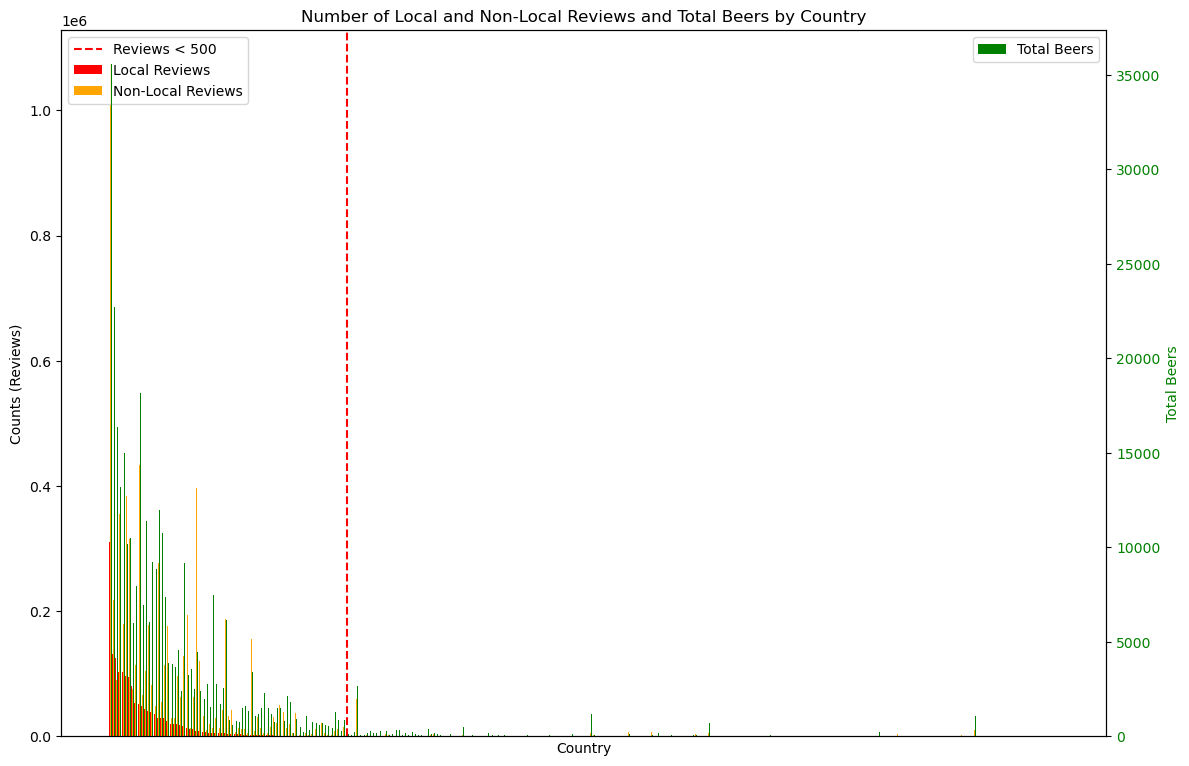

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.3
index = range(len(country_data))

# Plot the bars for the 3 different metrics on the primary y-axis
bar1 = ax1.bar(index, country_data['local_reviews'], bar_width, label='Local Reviews', color='red')
bar2 = ax1.bar([i + bar_width for i in index], country_data['non_local_reviews'], bar_width, label='Non-Local Reviews', color='orange')


ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Local and Non-Local Reviews and Total Beers by Country')


#Secondary axis (for the total number of beers)
ax2 = ax1.twinx()  # Create a second y-axis
bar3 = ax2.bar([i + 2 * bar_width for i in index], country_data['total_beers'], bar_width, label='Total Beers', color='green')

# Set labels for the secondary axis (right y-axis)
ax2.set_ylabel('Total Beers', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#Arbitrary cut off: where there are less than 500 non local and local reviews
for i in range(len(country_data)):  # Loop through all countries
    if country_data['local_reviews'].iloc[i] < 500 and country_data['non_local_reviews'].iloc[i] < 500:
        line_x = i + bar_width  # Place the line after the first pair of bars where condition is met
        break
if line_x is not None:
    ax1.axvline(x=line_x, color='red', linestyle='--', label='Reviews < 500')

# Now add the legend for the plot elements
ax1.legend(loc='upper left')
# Adjust layout for readability
plt.tight_layout()
ax1.set_xticks([])  # Remove x-ticks

plt.show()


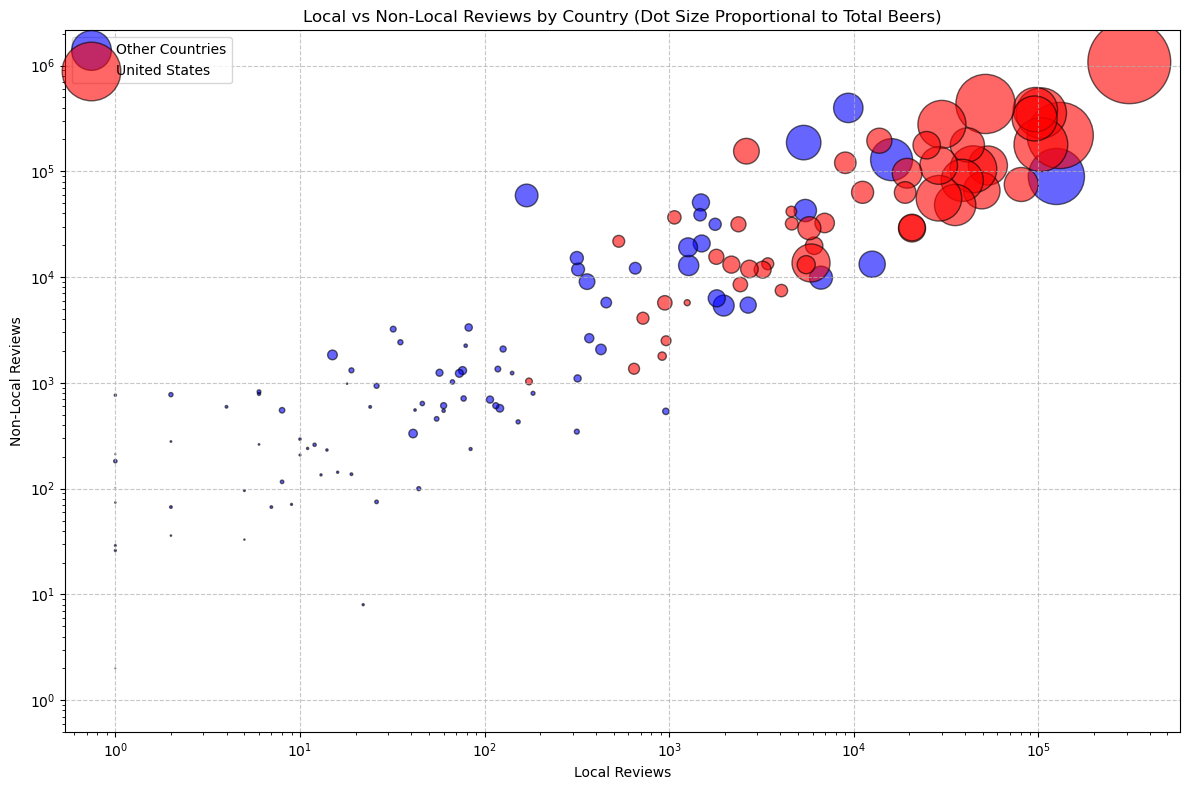

In [16]:
import matplotlib.pyplot as plt

# Define the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Identify locations that start with 'United States'
highlighted = country_data['location'].str.startswith('United States')

# Plot the dot plot for countries that are NOT 'United States' in blue
scatter = ax.scatter(
    country_data.loc[~highlighted, 'local_reviews'],
    country_data.loc[~highlighted, 'non_local_reviews'],
    s=country_data.loc[~highlighted, 'total_beers'] * 0.1,
    color='blue', 
    alpha=0.6,
    edgecolor='black',
    label='Other Countries'
)

# Plot the dot plot for countries that ARE 'United States' in red
scatter_us = ax.scatter(
    country_data.loc[highlighted, 'local_reviews'],
    country_data.loc[highlighted, 'non_local_reviews'],
    s=country_data.loc[highlighted, 'total_beers'] * 0.1,
    color='red',
    alpha=0.6,
    edgecolor='black',
    label='United States'
)

# Set plot labels and title
ax.set_xlabel('Local Reviews')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Non-Local Reviews')
ax.set_title('Local vs Non-Local Reviews by Country (Dot Size Proportional to Total Beers)')

# Optionally, add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


The figure above illustrates the bar chart better. The size of the circles are proportinal to the total number of beers produced by the location concerned.

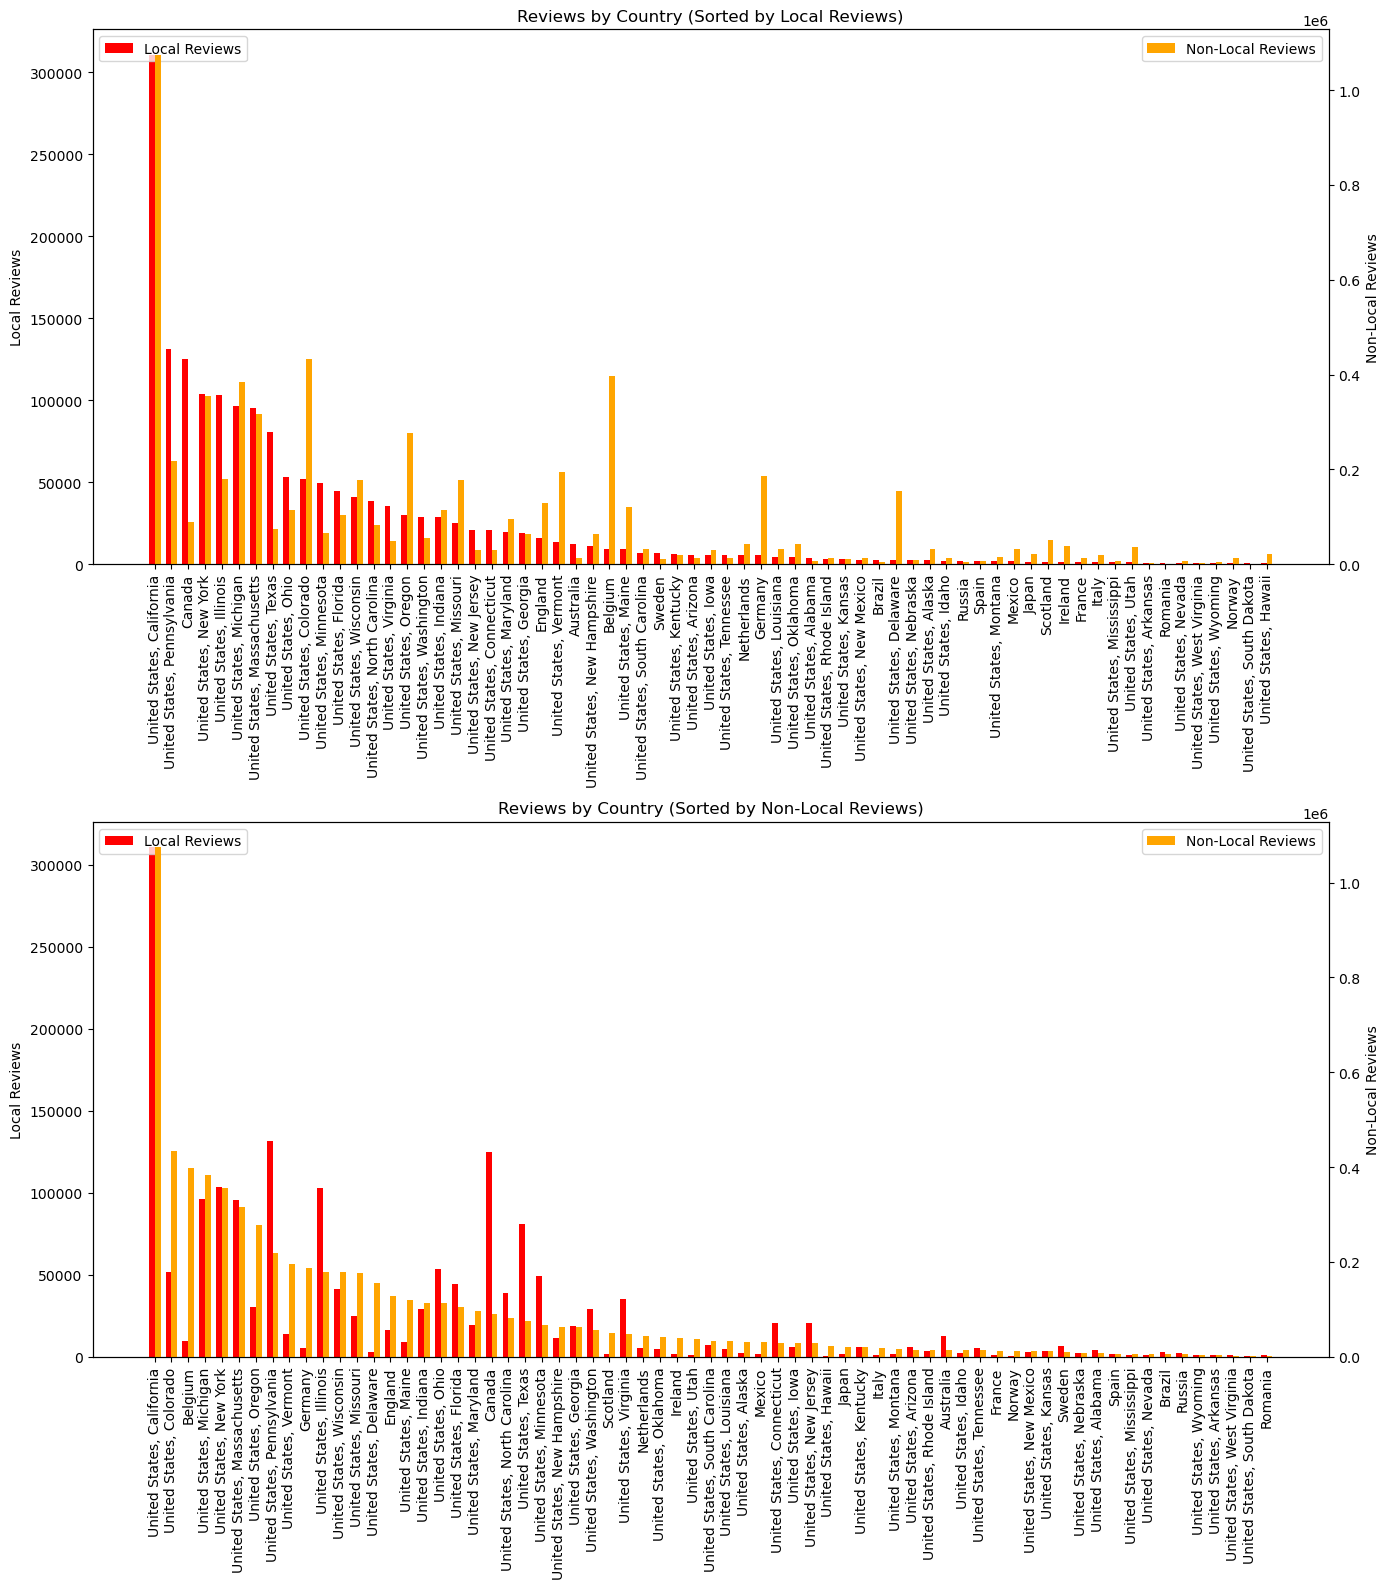

In [75]:
# Filter countries with at least 500 local and 500 non-local reviews
filtered_country_data = country_data[(country_data['local_reviews'] >= 500) & (country_data['non_local_reviews'] >= 500)]

# Sort separately for local and non-local reviews in descending order
sorted_local = filtered_country_data.sort_values(by='local_reviews', ascending=False)
sorted_non_local = filtered_country_data.sort_values(by='non_local_reviews', ascending=False)

# Create two stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

bar_width = 0.35
index_local = range(len(sorted_local))
index_non_local = range(len(sorted_non_local))

# First subplot: sorted by local reviews
ax1.bar(index_local, sorted_local['local_reviews'], bar_width, color='red', label='Local Reviews')
ax1.set_ylabel('Local Reviews')
ax1.set_title('Reviews by Country (Sorted by Local Reviews)')
ax1.set_xticks([i + bar_width / 2 for i in index_local])
ax1.set_xticklabels(sorted_local['location'], rotation=90)

# Create a twin axis for non-local reviews on the right
ax1_right = ax1.twinx()
ax1_right.bar([i + bar_width for i in index_local], sorted_local['non_local_reviews'], bar_width, color='orange', label='Non-Local Reviews')
ax1_right.set_ylabel('Non-Local Reviews')

# Legends for the first subplot
ax1.legend(loc='upper left')
ax1_right.legend(loc='upper right')

# Second subplot: sorted by non-local reviews
ax2.bar(index_non_local, sorted_non_local['local_reviews'], bar_width, color='red', label='Local Reviews')
ax2.set_ylabel('Local Reviews')
ax2.set_title('Reviews by Country (Sorted by Non-Local Reviews)')
ax2.set_xticks([i + bar_width / 2 for i in index_non_local])
ax2.set_xticklabels(sorted_non_local['location'], rotation=90)

# Create a twin axis for non-local reviews on the right
ax2_right = ax2.twinx()
ax2_right.bar([i + bar_width for i in index_non_local], sorted_non_local['non_local_reviews'], bar_width, color='orange', label='Non-Local Reviews')
ax2_right.set_ylabel('Non-Local Reviews')

# Legends for the second subplot
ax2.legend(loc='upper left')
ax2_right.legend(loc='upper right')
plt.tight_layout()
plt.show()


The figure above plots the number of local and non local reviews for each country based on ordering in descending order of either local and non local reviews. Visually we can see that there is a positive correlation between the 2. Therefore let us quantify this correlation.

Let's perform a Pearson test to verify and quantify this relationship. (A low p-value (e.g., < 0.05) would indicate that the correlation is statistically significant.)

In [66]:
from scipy.stats import pearsonr

correlation = filtered_country_data[['local_reviews', 'non_local_reviews']].corr().iloc[0, 1]
print(f"Correlation between local and non-local reviews: {correlation}")
correlation, p_value = pearsonr(filtered_country_data['local_reviews'], filtered_country_data['non_local_reviews'])
print(f"Pearson correlation: {correlation}, p-value: {p_value}")
print("The low p value suggests that this correlation output is indded statistically significant")

Correlation between local and non-local reviews: 0.82628489507921
Pearson correlation: 0.8262848950792101, p-value: 7.40318671639054e-18
The low p value suggests that this correlation output is indded statistically significant


Therefore since the 2 are linearly correlated, we could simply take the top N countries directly from either the ordering of local or non local reviews. We could also standardise the number of local and non local reviews and select our top N countries in this way. Standardisation needs to be used in order to consider the fact that the order of size of local and non local reviews are not the same. (There are many more non local reviews than there are local ones)

Below we are standardising using the z score [maybe insert equation here] the number local and non local reviews to obtain the top N countries- here we are are not putting a weight on either local or non local reviews.

[Alternative reasoning] Based on the scatter plot above we can directly see that this dataset not only contains a high amount of US beers but also a large proportion of the data is also has both local and non-local US beers and therefore it makes sense for us to focus our analysis in this direction for the BeerAdvocate dataset.

In [74]:
N = 50
#Calculate the mean and standard deviation for both columns
local_mean = country_data['local_reviews'].mean()
local_std = country_data['local_reviews'].std()

non_local_mean = country_data['non_local_reviews'].mean()
non_local_std = country_data['non_local_reviews'].std()

#Standardize the 'local_reviews' and 'non_local_reviews' columns using the z score
country_data['local_reviews_scaled'] = (country_data['local_reviews'] - local_mean) / local_std
country_data['non_local_reviews_scaled'] = (country_data['non_local_reviews'] - non_local_mean) / non_local_std

#Calculate a combined score (average of the standardized values)
country_data['combined_score'] = (country_data['local_reviews_scaled'] + country_data['non_local_reviews_scaled']) / 2

#Sort the countries by the combined score in descending order to get the top N countries
top_n_countries = country_data.sort_values(by='combined_score', ascending=False).head(N)  # Replace N with the desired number of top countries


print(top_n_countries[['location', 'local_reviews', 'non_local_reviews', 'combined_score']])


                          location  local_reviews  non_local_reviews  \
207      United States, California       310621.0          1074377.0   
224        United States, Michigan        96266.0           383282.0   
234        United States, New York       103588.0           355362.0   
240    United States, Pennsylvania       131261.0           218250.0   
223   United States, Massachusetts        95340.0           316008.0   
208        United States, Colorado        51676.0           433127.0   
215        United States, Illinois       103115.0           178791.0   
28                          Canada       125101.0            89427.0   
15                         Belgium         9335.0           397510.0   
239          United States, Oregon        30018.0           277623.0   
245           United States, Texas        80715.0            75057.0   
252       United States, Wisconsin        41216.0           177518.0   
237            United States, Ohio        53235.0           1134

Based on the z score we can see that many of the locations that have a lot of both local and non local reviews are the US states.